# YOMA ISSUER AGENT

## 1. Initialise a controller for Issuer

In [1]:
%autoawait
import time
import asyncio
from termcolor import colored,cprint

from aries_basic_controller.aries_controller import AriesAgentController
    
WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_PORT = 8052
WEBHOOK_BASE = ""
ADMIN_URL = "http://yoma-agent:8051"

# Based on the aca-py agent you wish to control
agent_controller = AriesAgentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL)
    

Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7fb930134850>


IPython autoawait is `on`, and set to use `asyncio`


## 2. Register Listeners

The handler should get called every time the controller receives a webhook with the topic issue_credential, printing out the payload. The agent calls to this webhook every time it receives an issue-credential protocol message from a credential.

In [2]:
loop = asyncio.get_event_loop()
loop.create_task(agent_controller.listen_webhooks())

def cred_handler(payload):
    print("Handle Credentials")
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    attributes = payload['credential_proposal_dict']['credential_proposal']['attributes']
    print(f"Credential exchange {exchange_id}, role: {role}, state: {state}")
    print(f"Offering: {attributes}")
    
cred_listener = {
    "topic": "issue_credential",
    "handler": cred_handler
}

def connections_handler(payload):
    global STATE
    connection_id = payload["connection_id"]
    print("Connection message", payload, connection_id)
    STATE = payload['state']
    if STATE == 'active':
#         print('Connection {0} changed state to active'.format(connection_id))
        print(colored("Connection {0} changed state to active".format(connection_id), "red", attrs=["bold"]))


connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

agent_controller.register_listeners([cred_listener,connection_listener], defaults=True)


## 3a. Use a previously written schema

In [6]:
schema_id = '3pMbbpqEEGzSQkV79jGmDH:2:Youth Member:0.0.1'

In [22]:
schema_id = '3pMbbpqEEGzSQkV79jGmDH:2:Ecosystem Member:0.0.1'

## 3b. (OPTIONAL) Write a Schema to the Ledger

For more details see the [schema-api notebook](http://localhost:8888/notebooks/schema_api.ipynb)

**Note: You will only be able to do this once unless you change the schema_name or version. Once you have a schema written to the ledger it can be reused by multiple entities**

In [6]:
# Define you schema name - must be unique on the ledger
schema_name = "Youth Member"
# Can version the schema if you wish to update it
schema_version = "0.0.1"
# Define any list of attributes you wish to include in your schema
attributes = ["fullname", "mobile", "email"]

response = await agent_controller.schema.write_schema(schema_name, attributes, schema_version)
schema_id = response["schema_id"]
print(schema_id)

3pMbbpqEEGzSQkV79jGmDH:2:Youth Member:0.0.1


In [23]:
# Define you schema name - must be unique on the ledger
schema_name = "Ecosystem Member"
# Can version the schema if you wish to update it
schema_version = "0.0.1"
# Define any list of attributes you wish to include in your schema
attributes = ["orgname", "op_type", "url"]

response = await agent_controller.schema.write_schema(schema_name, attributes, schema_version)
schema_id = response["schema_id"]
print(schema_id)


FPHUv7MUTAb3qXXdu5STCt:2:Ecosystem Member:0.0.1


## 4. Write a Credential Definition to the Ledger

**Note: Again this can only be done once per issuer, per schema_id.**

In [24]:
response = await agent_controller.definitions.write_cred_def(schema_id)

cred_def_id = response["credential_definition_id"]
print(cred_def_id)

FPHUv7MUTAb3qXXdu5STCt:3:CL:193375:default


**Note: You should be able to see both schema and definition transactions on Sovrin Stagingnet network with [Indyscan](https://indyscan.io/home/SOVRIN_STAGINGNET)**

## 5. Populate the Attribues to Issue to Idenity Holder (User)

We will issue a credential to the identity holder consisting of the following attributes:

credential_attributes = [
    {"name": "fullname", "value": name},
    {"name": "skill", "value": "PyDentity SSI Ninja"},
    {"name": "age", "value": age}
]

The notebook will ask you to input the identity holder's full name and age which will be used to populate the schema above with the identity holders attribute information.

In [8]:
name=input("Please enter your name and surname: ")
mobile=input("Please enter your mobile number: ")
email=input("Please enter your email number: ")
credential_attributes = [
    {"name": "fullname", "value": name},
    {"name": "mobile", "value": mobile},
    {"name": "email", "value": email}
]
print(credential_attributes)

Please enter your name and surname: Lohan Spies
Please enter your mobile number: 0831234567
Please enter your email number: t@t.com
[{'name': 'fullname', 'value': 'Lohan Spies'}, {'name': 'mobile', 'value': '0831234567'}, {'name': 'email', 'value': 't@t.com'}]


In [25]:
orgname=input("Please enter your organisation name: ")
op_type=input("Please enter your Opportunity Provider type [learning,earning, impact]: ")
url=input("Please enter organisation url: ")

credential_attributes = [
    {"name": "orgname", "value": orgname},
    {"name": "op_type", "value": op_type},
    {"name": "url", "value": url}
]
print(credential_attributes)

Please enter your organisation name: DIDx
Please enter your Opportunity Provider type [learning,earning, impact]: learning
Please enter organisation url: www.didx.co.za
[{'name': 'orgname', 'value': 'DIDx'}, {'name': 'op_type', 'value': 'learning'}, {'name': 'url', 'value': 'www.didx.co.za'}]


## 7. Download Identity Holder Mobile SSI Wallet
Please download a mobile SSI wallet such as [Connect.me](https://connect.me/), [Trinsic](https://trinsic.id/trinsic-wallet/) or any other Aries compatible wallet.

## 8. Create a connection invitation to scan with the Mobile SSI Wallet

To make a connection with an identity holders wallet we must create a connection invitation and present the QR code to be scanned by the identity holders wallet. The identity holder scan this QR code and then communicate back to the agent through the exposed ngrok endpoint.

Once a connection is in an active state, the agent and the identity holders mobile wallet now have a secure pairwise relationship over which they can exchange verifiable credentials.

## 8a. Check for any existing connections

In [19]:
# Check for existing connections
connection = await agent_controller.connections.get_connections()
print("EXISTING CONNECTIONS")
for key, value in connection.items():
    for item in value:
        print('ConnectionID:', item['connection_id'], 'Status:',item['state'])

EXISTING CONNECTIONS
ConnectionID: b0b99d5a-0f68-4fb0-9cea-45ff460ad4a6 Status: active
ConnectionID: 961f9af8-c9ed-4fc4-9866-6b00d48fdaa8 Status: active
ConnectionID: fab3272b-1484-4d0f-a534-6419dcc2e050 Status: invitation
ConnectionID: 3abfbc78-465b-48b5-94d5-ddce177de6ab Status: invitation
ConnectionID: 5e8b94fb-d64d-4ff6-86b8-ef6929962b24 Status: invitation


## 8b. Create an Invitation

In [27]:
# Create Invitation
invite = await agent_controller.connections.create_invitation()
connection_id = invite["connection_id"]
print("Connection ID", connection_id)
print("Invitation")
print(invite['invitation_url'])
inviteURL = invite['invitation_url']
invitation = invite['invitation']
print('\n ',invitation)

Connection message {'invitation_key': 'AsysiWE8yoLSrnhkuFGjqiBSr46UCiWLU9NnxC7dmuso', 'their_role': 'invitee', 'accept': 'auto', 'invitation_mode': 'once', 'created_at': '2021-03-11 19:23:46.917409Z', 'routing_state': 'none', 'rfc23_state': 'invitation-sent', 'state': 'invitation', 'updated_at': '2021-03-11 19:23:46.917409Z', 'connection_id': 'ddf44da2-4da9-4dc9-a5d5-3e765f43e63b'} ddf44da2-4da9-4dc9-a5d5-3e765f43e63b
Connection message {'invitation_key': 'AsysiWE8yoLSrnhkuFGjqiBSr46UCiWLU9NnxC7dmuso', 'their_role': 'invitee', 'accept': 'auto', 'invitation_mode': 'once', 'created_at': '2021-03-11 19:23:46.917409Z', 'routing_state': 'none', 'rfc23_state': 'invitation-sent', 'state': 'invitation', 'updated_at': '2021-03-11 19:23:46.917409Z', 'connection_id': 'ddf44da2-4da9-4dc9-a5d5-3e765f43e63b'} ddf44da2-4da9-4dc9-a5d5-3e765f43e63b
Connection ID ddf44da2-4da9-4dc9-a5d5-3e765f43e63b
Invitation
https://24feee5e7d3a.ngrok.io?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3Bl

## 8c. Generate QR Code to be scanned with Mobile SSI Wallet

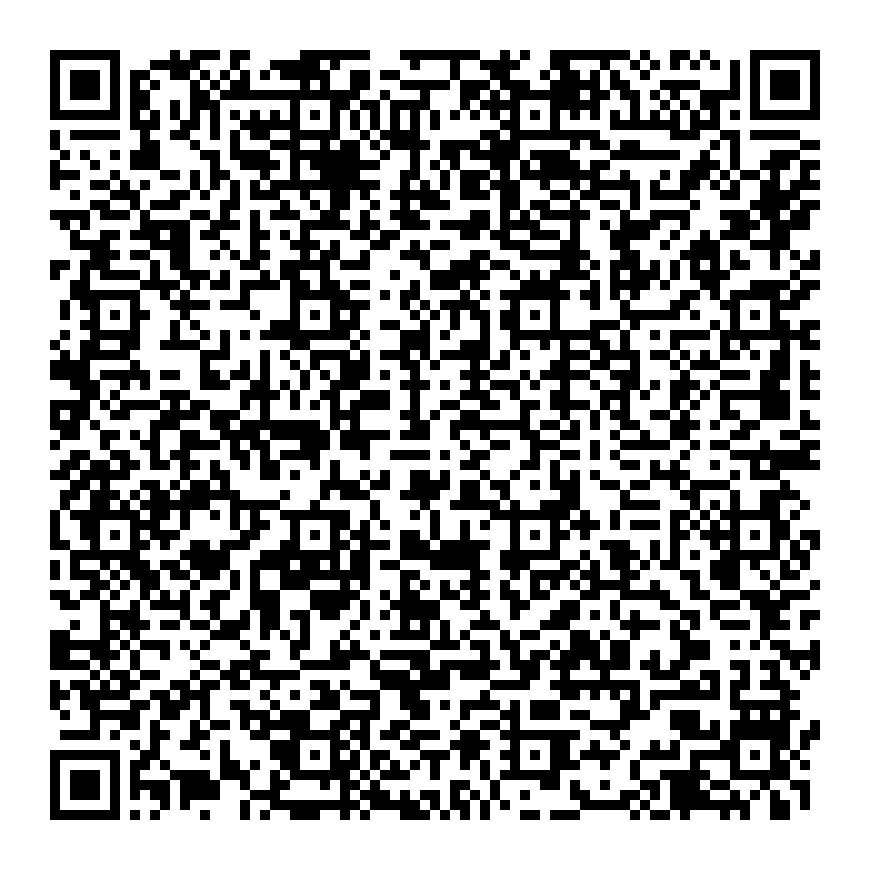

In [29]:
import qrcode
# Link for connection invitation
input_data = inviteURL
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)
qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('issuer_agent_invite_QRcode.png')

from IPython.display import Image
Image(width=400, filename='./issuer_agent_invite_QRcode.png')

## 8d. Check if established connection is in active state

In [20]:
import time

# print('Current state for ConnectionId {} is {}'.format(connection_id,STATE))
print(colored("Current state for ConnectionId {} is {}".format(connection_id,STATE), "magenta", attrs=["bold"]))
while STATE != 'active':
#     print('ConnectionId {0} is not in active state yet'.format(connection_id))
    print(colored("ConnectionId {0} is not in active state yet".format(connection_id), "yellow", attrs=["bold"]))
    trust_ping = await agent_controller.messaging.trust_ping(connection_id,'hello!')
#     print('Trust ping send to ConnectionId {0} to activate connection'.format(trust_ping))
    print(colored("Trust ping send to ConnectionId {0} to activate connection".format(trust_ping), "blue", attrs=["bold"]))
    time.sleep(5)
    
# print('ConnectionId: {0} is now active. Continue with notebook'.format(connection_id))
print(colored("ConnectionId: {0} is now active. Continue with notebook".format(connection_id), "green", attrs=["bold"]))


Current state for ConnectionId 961f9af8-c9ed-4fc4-9866-6b00d48fdaa8 is active
ConnectionId: 961f9af8-c9ed-4fc4-9866-6b00d48fdaa8 is now active. Continue with notebook


## 9. Send Credential

This sends a credential to a identity holder (User), and automates the rest of the protocol.

There are other ways to issue a credential that require multiple api calls.

**Arguments**
* connection_id: The connection_id of the holder you wish to issue to (MUST be in active state)
* schema_id: The id of the schema you wish to issue
* cred_def_id: The definition (public key) to sign the credential object. This must refer to the schema_id and be written to the ledger by the same public did that is currently being used by the agent.
* attributes: A list of attribute objects as defined above. Must match the schema attributes.
* comment (optional): Any string, defaults to ""
* auto_remove (optional): Boolean, defaults to True. I believe this removes the record of this credential once it has been issued. (TODO: double check)
* trace (optional): Boolean, defaults to False. **Not entirely sure about this one, believe its for logging. Also when set to True it throws an error**

In [28]:
record = await agent_controller.issuer.send_credential(connection_id, schema_id, cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")


Credential exchange 0f864db4-ab13-4e25-98b8-ab5f3a9691fe, role: issuer, state: offer_sent
Handle Credentials
Credential exchange 0f864db4-ab13-4e25-98b8-ab5f3a9691fe, role: issuer, state: offer_sent
Offering: [{'name': 'orgname', 'value': 'DIDx'}, {'name': 'op_type', 'value': 'learning'}, {'name': 'url', 'value': 'www.didx.co.za'}]
Handle Credentials
Credential exchange 0f864db4-ab13-4e25-98b8-ab5f3a9691fe, role: issuer, state: offer_sent
Offering: [{'name': 'orgname', 'value': 'DIDx'}, {'name': 'op_type', 'value': 'learning'}, {'name': 'url', 'value': 'www.didx.co.za'}]
Handle Credentials
Credential exchange 0f864db4-ab13-4e25-98b8-ab5f3a9691fe, role: issuer, state: request_received
Offering: [{'name': 'orgname', 'value': 'DIDx'}, {'name': 'op_type', 'value': 'learning'}, {'name': 'url', 'value': 'www.didx.co.za'}]
Handle Credentials
Credential exchange 0f864db4-ab13-4e25-98b8-ab5f3a9691fe, role: issuer, state: request_received
Offering: [{'name': 'orgname', 'value': 'DIDx'}, {'name':

## 10. Accept credential in Mobile SSI Wallet

## 11. End of Tutorial

Be sure to terminate the controller so you can run another tutorial.

In [ ]:
response = await agent_controller.terminate()
print(response)

# Proceed to Part 4 on [Verifier Notebook](http://localhost:8889/notebooks/Part%204%20-%20Verify%20a%20Presentation.ipynb)

Here you will present the attributes issued to you within this tutorial to a verifying entity.